In [1]:
import pandas as pd

main_df = pd.read_csv('./data/bsm_data_train.csv')
main_df = main_df.drop_duplicates('ident_bag', keep='first').reset_index(drop=True)

# Формирование целевой переменной

In [2]:
main_df['MessageReceivedMinutes'] = pd.to_datetime(main_df['MessageReceivedDate']).apply(lambda x: x.value) / 1000000000 // 60
main_df['MessageReceivedMinutes'] = main_df['MessageReceivedMinutes'].astype(int)
main_df['MessageReceivedMinutes'] -= main_df['MessageReceivedMinutes'].min()
main_df = main_df.sort_values(by='MessageReceivedMinutes')

main_df['ProcessingTime'] = (pd.to_datetime(main_df.MessageProcessedDate) - pd.to_datetime(main_df.MessageReceivedDate)).apply(lambda x: x.seconds)

In [3]:
target = main_df.MessageReceivedMinutes.value_counts().sort_index().rename('target')

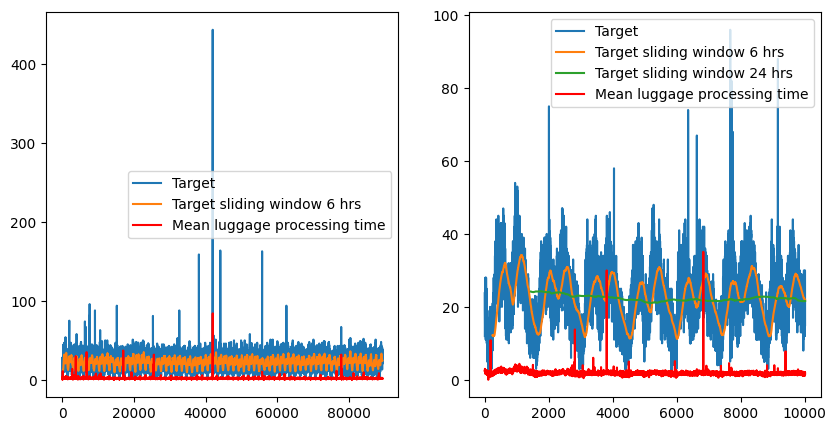

In [4]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].plot(target, label='Target')
axes[0].plot(target.rolling(240).mean(), label='Target sliding window 6 hrs')
axes[0].plot(main_df.groupby('MessageReceivedMinutes').ProcessingTime.mean(), color='red', label='Mean luggage processing time')
axes[0].legend()

axes[1].plot(target[:10000], label='Target')
axes[1].plot(target[:10000].rolling(240).mean(), label='Target sliding window 6 hrs')
axes[1].plot(target[:10000].rolling(1440).mean(), label='Target sliding window 24 hrs')
axes[1].plot(main_df.groupby('MessageReceivedMinutes').ProcessingTime.mean()[:10000], color='red', label='Mean luggage processing time')

axes[1].legend()

# Доп данные + EDA

In [5]:
rasp_data = pd.read_csv('./data/flight_rasp_data.csv')
main_df = main_df.join(rasp_data.set_index('i_id'), on='i_id')
main_df = main_df.drop(columns=['pax_id_hash', 'm_city_rus1', 'DateEvent'])

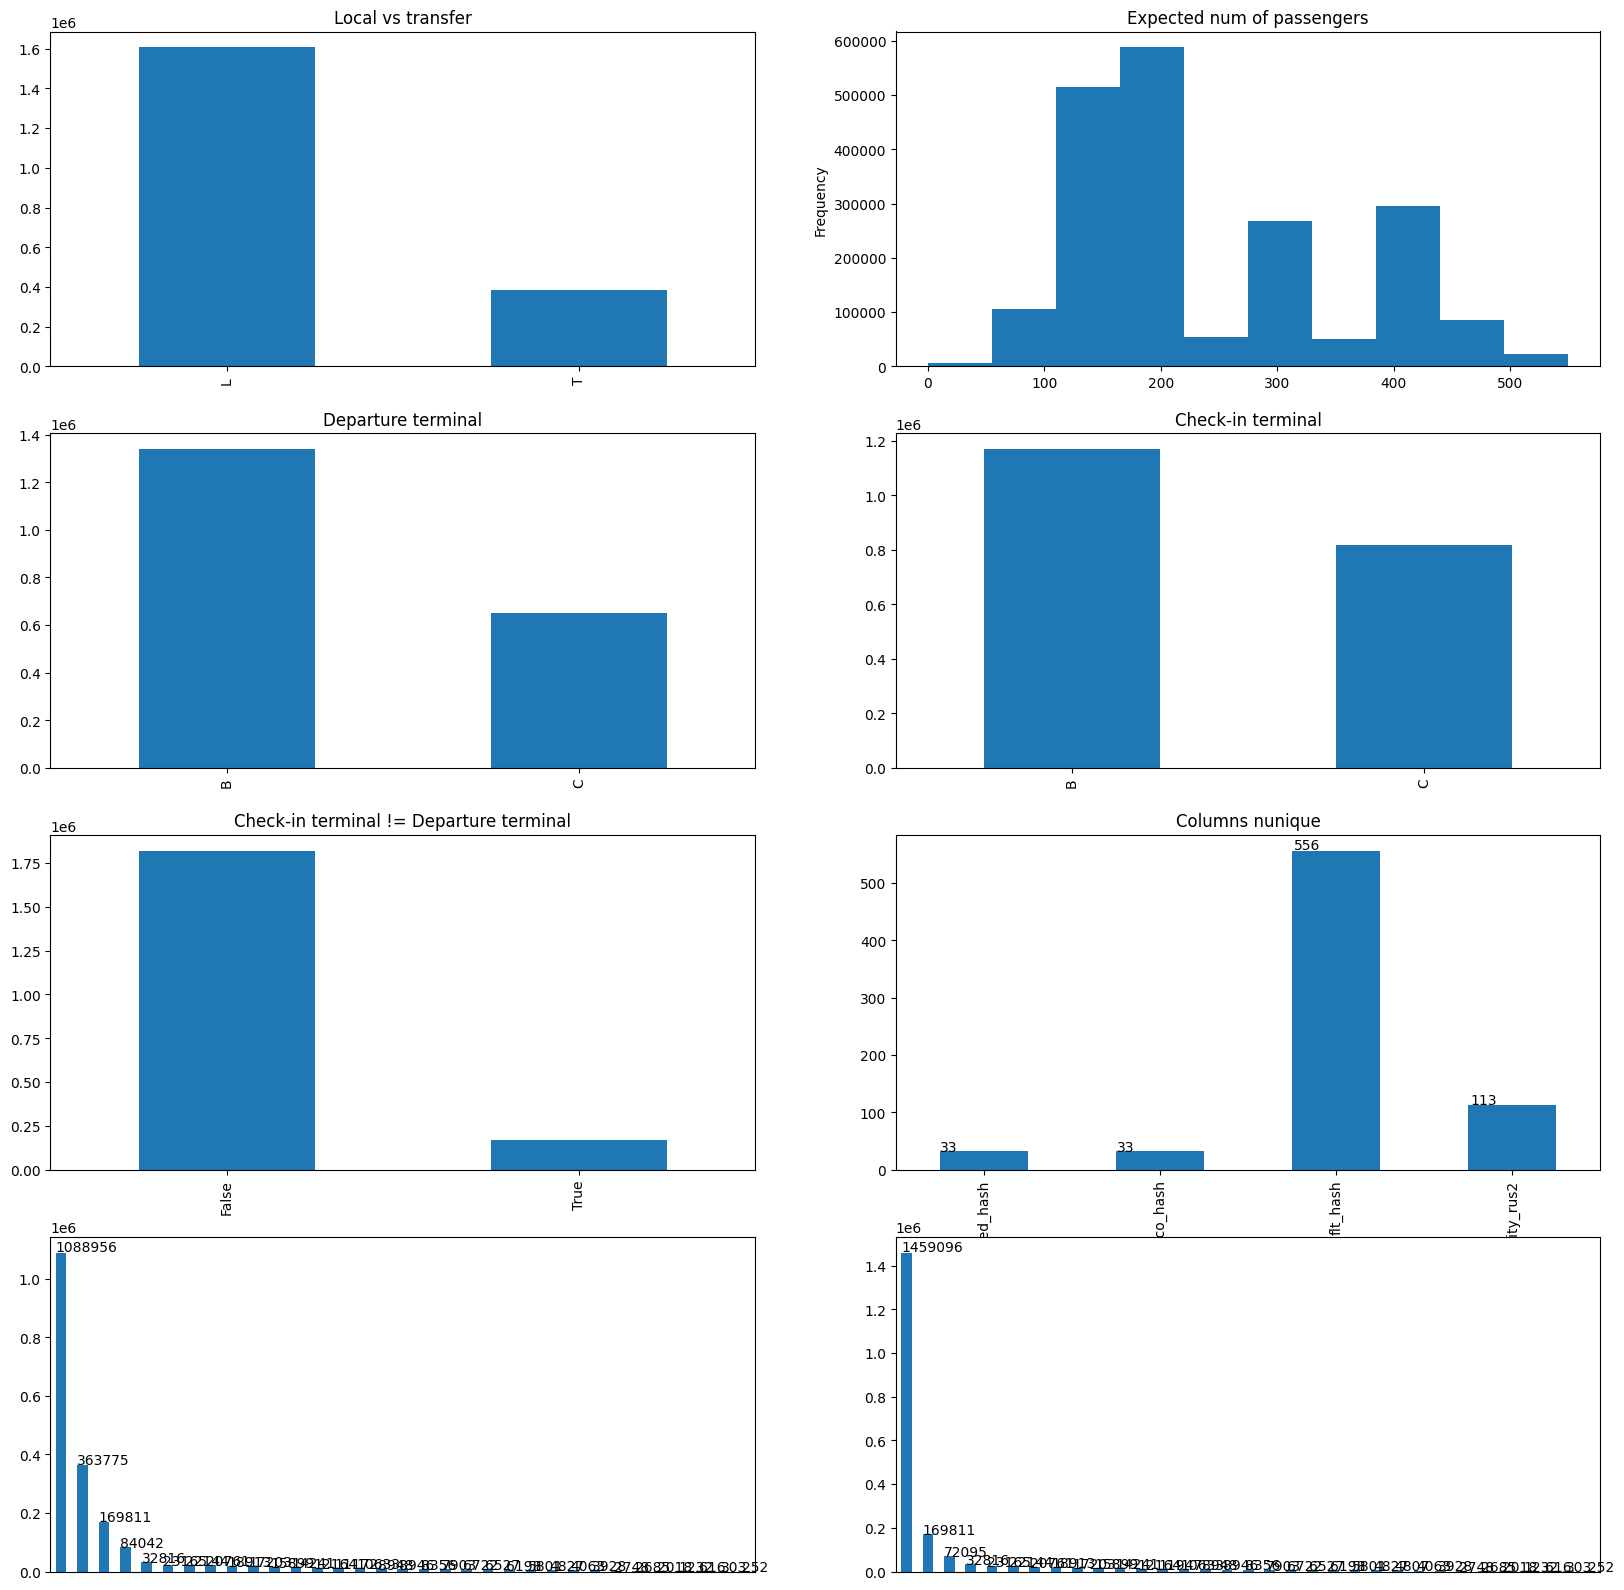

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))


main_df.local_or_transfer.value_counts().plot.bar(ax=axes[0, 0])
main_df.config.plot.hist(ax=axes[0, 1])
main_df.departure_terminal.value_counts().plot.bar(ax=axes[1, 0])
main_df.checkin_terminal.value_counts().plot.bar(ax=axes[1, 1])
(main_df.departure_terminal != main_df.checkin_terminal).value_counts().plot.bar(ax=axes[2, 0])
main_df[['airline_grouped_hash', 'cco_hash', 'flt_hash', 'm_city_rus2']].nunique().plot.bar(ax=axes[2, 1])


axes[0, 0].set_title('Local vs transfer')
axes[0, 1].set_title('Expected num of passengers')
axes[1, 0].set_title('Departure terminal')
axes[1, 1].set_title('Check-in terminal')
axes[2, 0].set_title('Check-in terminal != Departure terminal')
axes[2, 1].set_title('Columns nunique')

for p in axes[2, 1].patches:
    axes[2, 1].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
main_df['airline_grouped_hash'].value_counts().plot.bar(ax=axes[3, 0])
axes[3, 0].xaxis.set_visible(False)
main_df['cco_hash'].value_counts().plot.bar(ax=axes[3, 1])
axes[3, 1].xaxis.set_visible(False)

for p in axes[3, 0].patches:
    axes[3, 0].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
for p in axes[3, 1].patches:
    axes[3, 1].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Простейший feature engineering и построении матрицы корреляции

#### Убираем лишние фичи и кодируем некоторые

In [7]:
main_df = main_df.drop(columns=['ident_bag', 'i_id', 'MessageProcessedDate', 'TagNumber'], errors='ignore')
main_df['is_dep_B'] = main_df.departure_terminal == 'B'
main_df['is_local'] = main_df.local_or_transfer == 'L'
main_df['departure_equals_checkin'] = (main_df['departure_terminal'] == main_df['checkin_terminal']).astype('int')
main_df = main_df.drop(columns=['local_or_transfer', 'departure_terminal', 'checkin_terminal', 'flt_hash'])

main_df['ProcessingTime'] /= main_df.ProcessingTime.max()

#### Добавляем фичи о времени вылета рейса

In [8]:
main_df['dep_day'] = pd.to_datetime(main_df['t_st']).apply(lambda x: x.dayofweek) / 6
main_df['dep_hour'] = pd.to_datetime(main_df['t_st']).apply(lambda x: x.hour) / 23

main_df = main_df.drop(columns='t_st')

#### Добавляем фичу с количеством рейсов, вылетающих через 3 часа

In [9]:
from tqdm import tqdm

rasp_data['t_st'] = pd.to_datetime(rasp_data.t_st).apply(lambda x: x.timestamp())
rasp_data['t_st'] -= rasp_data.t_st.min()
rasp_data['t_st'] //= 60

nflights_next_3_hours = list()

for e in tqdm(main_df.MessageReceivedMinutes.unique()):
    nflights_next_3_hours.append((e, (rasp_data.t_st - e).between(0, 180).sum()))
    
main_df = main_df.merge(pd.DataFrame.from_records(nflights_next_3_hours, columns=['MessageReceivedMinutes', 'nflights_next_3_hours']), on='MessageReceivedMinutes')
main_df['nflights_next_3_hours'] /= main_df.nflights_next_3_hours.max()

100%|██████████████████████████████████████████████████████████████████████████| 89213/89213 [00:32<00:00, 2771.42it/s]


#### Разбираемся с хешированными фичами

In [14]:
from sklearn.feature_extraction import FeatureHasher

hasher = FeatureHasher(n_features=10)

hashed = hasher.transform(main_df[['airline_grouped_hash', 'cco_hash']].to_dict(orient='records')).toarray()
hashed.shape

(1989376, 10)

In [15]:
main_df = pd.concat([main_df, pd.DataFrame(hashed)], axis=1)

#### Города превращаем в километры пути

In [16]:
kilometers_df = pd.read_csv('kilometers.csv').drop(columns=['Unnamed: 0']).rename(columns={'0': 'm_city_rus2'}).set_index('m_city_rus2').dropna()
main_df = main_df.join(kilometers_df, on='m_city_rus2')
main_df.loc[main_df.km.isna(), 'km'] = main_df.km.mean()
main_df['km'] /= main_df.km.max()

#### Матрица корреляции

In [17]:
corr = main_df.merge(target.reset_index().rename(columns={'index': 'MessageReceivedMinutes'}), on='MessageReceivedMinutes').corr()
corr.style.background_gradient(cmap='coolwarm')

,MessageReceivedMinutes,ProcessingTime,config,is_dep_B,is_local,departure_equals_checkin,dep_day,dep_hour,nflights_next_3_hours,0,1,2,3,4,5,6,7,8,9,km,target
MessageReceivedMinutes,1.000000,-0.024186,0.018298,0.003785,-0.007039,0.018626,-0.039190,0.009427,0.099387,0.000251,0.002629,-0.009863,-0.018409,0.003486,0.018741,0.023978,-0.000524,0.018818,0.000493,0.015424,0.006379
ProcessingTime,-0.024186,1.000000,0.009420,0.001757,-0.011911,0.003421,0.023085,0.030038,0.016930,-0.006318,0.005948,-0.001798,-0.000495,-0.011918,0.003032,-0.000081,-0.001255,0.008209,-0.006046,0.018411,0.365313
config,0.018298,0.009420,1.000000,-0.201550,0.127409,0.147661,-0.004227,0.207812,0.093757,-0.002390,0.062051,0.108099,-0.111086,0.147060,0.138026,0.113225,-0.043555,-0.088479,0.001212,0.787936,0.095589
is_dep_B,0.003785,0.001757,-0.201550,1.000000,-0.227080,-0.207977,-0.016304,0.145126,-0.042453,0.262449,-0.182834,-0.515799,0.055650,-0.032422,-0.241970,-0.044407,-0.007600,0.726755,-0.261353,-0.184211,-0.029545
is_local,-0.007039,-0.011911,0.127409,-0.227080,1.000000,-0.075917,0.018747,-0.059645,0.299440,-0.088113,0.001221,0.062368,0.110052,0.065820,-0.053141,0.015515,0.032074,-0.271071,0.212715,0.091469,0.117810
departure_equals_checkin,0.018626,0.003421,0.147661,-0.207977,-0.075917,1.000000,0.002841,-0.026217,-0.057931,-0.055869,-0.003502,0.110441,-0.840058,0.042500,0.921509,0.009508,0.021331,0.327556,-0.498337,0.206075,-0.011366
dep_day,-0.039190,0.023085,-0.004227,-0.016304,0.018747,0.002841,1.000000,0.006673,0.039051,-0.006213,0.008288,0.026879,0.009725,-0.024153,0.005321,-0.011777,0.016690,0.001509,-0.021983,0.015818,0.068382
dep_hour,0.009427,0.030038,0.207812,0.145126,-0.059645,-0.026217,0.006673,1.000000,0.112183,-0.003300,0.085702,-0.009832,0.012721,-0.143745,-0.052587,-0.020637,-0.004422,0.156912,-0.144066,0.282474,0.190468
nflights_next_3_hours,0.099387,0.016930,0.093757,-0.042453,0.299440,-0.057931,0.039051,0.112183,1.000000,0.037188,-0.012162,0.090461,0.072882,-0.026211,-0.046670,0.053765,0.014022,-0.050873,-0.015493,0.089375,0.392853
0,0.000251,-0.006318,-0.002390,0.262449,-0.088113,-0.055869,-0.006213,-0.003300,0.037188,1.000000,-0.002075,0.268684,-0.118572,0.025182,-0.044986,0.005634,0.012704,0.196450,-0.360137,-0.054669,-0.025563


# Исследование Target как временного ряда методами эконометрики

<AxesSubplot:>

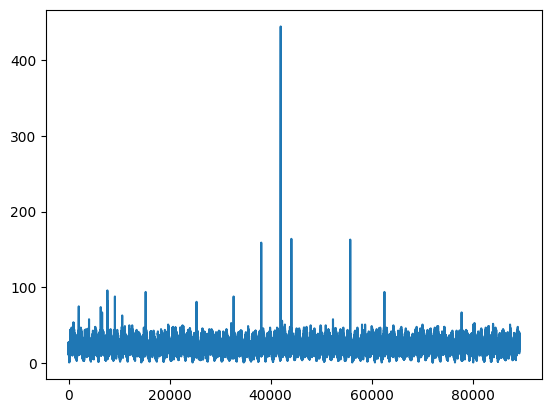

In [10]:
target.plot()

C:\Program Files\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


DF criterion: 2.5070376665141503e-26


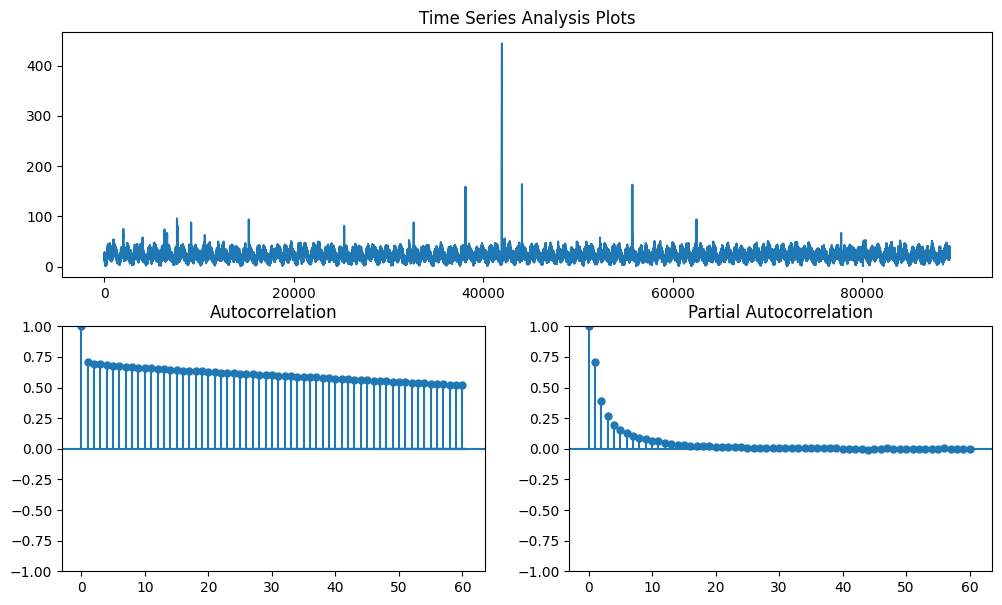

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

target.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
plot_acf(target, lags=60, ax=acf_ax, alpha=0.5)
plot_pacf(target, lags=60, ax=pacf_ax, alpha=0.5)

print(f"DF criterion: {adfuller(target)[1]}")

C:\Program Files\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


DF criterion: 6.959083326902508e-26, Box-Cox lambda: 0.7031593032409162


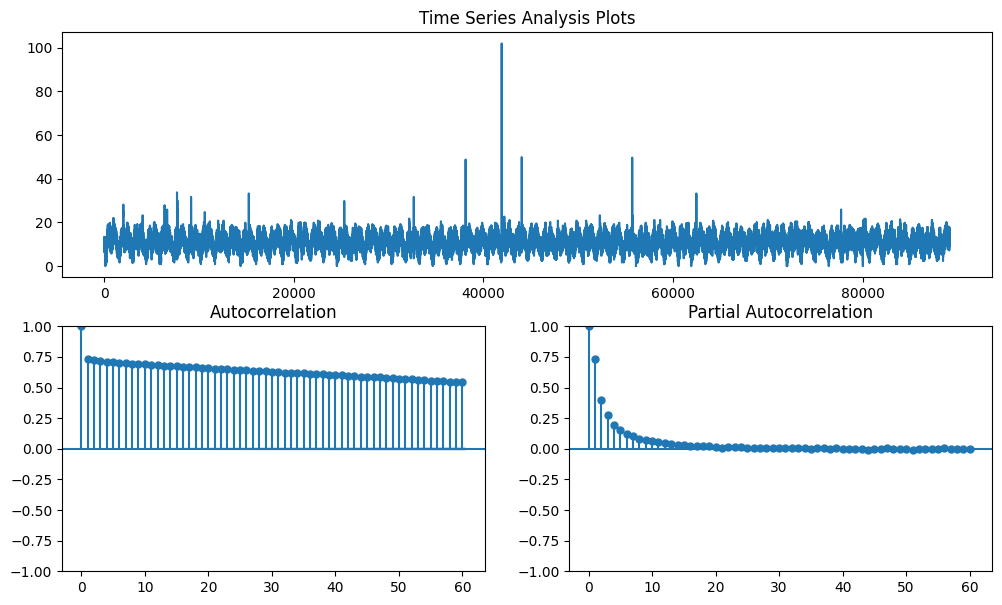

In [12]:
from scipy.stats import boxcox

target_boxcox, lmbda = boxcox(target)

fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts_ax.plot(target_boxcox)
ts_ax.set_title('Time Series Analysis Plots')
plot_acf(target_boxcox, lags=60, ax=acf_ax, alpha=0.5)
plot_pacf(target_boxcox, lags=60, ax=pacf_ax, alpha=0.5)

print(f"DF criterion: {adfuller(target_boxcox)[1]}, Box-Cox lambda: {lmbda}")

C:\Program Files\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


DF criterion: 0.0


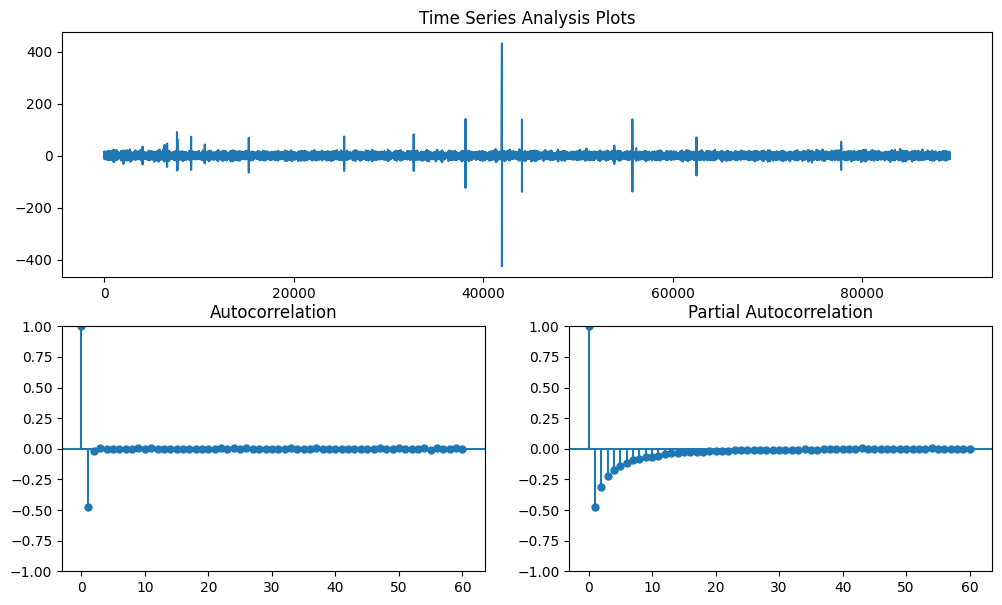

In [13]:
shift = 1

target_shifted = target - target.shift(shift)
target_shifted = target_shifted[shift:]

fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts_ax.plot(target_shifted)
ts_ax.set_title('Time Series Analysis Plots')
plot_acf(target_shifted, lags=60, ax=acf_ax, alpha=0.5)
plot_pacf(target_shifted, lags=60, ax=pacf_ax, alpha=0.5)

print(f"DF criterion: {adfuller(target_shifted)[1]}")

В целом, ряд изначально был близок к стационарности, поэтому смысла делать прямые и обратные преобразования я не вижу

# Запись данных для обучения по всем а/к вместе

In [26]:
main_df['config'] /= main_df.config.max()
X = main_df.drop(columns=['MessageReceivedDate', 'airline_grouped_hash', 'cco_hash', 'm_city_rus2']).groupby('MessageReceivedMinutes').mean()
X

,ProcessingTime,config,is_dep_B,is_local,departure_equals_checkin,dep_day,dep_hour,nflights_next_3_hours,0,1,2,3,4,5,6,7,8,9,km
MessageReceivedMinutes,,,,,,,,,,,,,,,,,,,
0,0.022124,0.465455,0.750000,0.833333,1.000000,0.833333,0.112319,0.554217,0.000000,-0.166667,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.583333,-1.000000,0.257763
1,0.023230,0.405909,0.625000,0.750000,0.958333,0.833333,0.170290,0.530120,-0.041667,-0.041667,0.083333,0.041667,0.083333,-0.041667,-0.041667,0.0,0.500000,-0.791667,0.281622
2,0.020228,0.337922,0.714286,0.714286,0.785714,0.833333,0.152174,0.530120,-0.071429,-0.071429,0.071429,0.214286,0.000000,-0.214286,-0.071429,0.0,0.357143,-0.642857,0.172350
3,0.023288,0.341914,0.526316,0.894737,1.000000,0.833333,0.107551,0.530120,-0.105263,-0.105263,0.000000,0.000000,0.000000,0.000000,-0.105263,0.0,0.315789,-0.736842,0.210267
4,0.026549,0.392386,0.500000,0.750000,0.937500,0.833333,0.160326,0.530120,-0.062500,0.000000,0.062500,0.062500,0.000000,-0.062500,0.125000,0.0,0.437500,-0.562500,0.229426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,0.017699,0.596364,0.392857,0.785714,1.000000,0.666667,0.138199,0.578313,0.000000,-0.035714,0.178571,0.035714,0.321429,0.035714,0.071429,0.0,0.250000,-0.500000,0.337987
89276,0.017383,0.593506,0.321429,0.892857,1.000000,0.666667,0.107143,0.578313,0.000000,-0.035714,0.071429,0.035714,0.285714,0.035714,0.142857,0.0,0.142857,-0.178571,0.292948
89277,0.018615,0.590219,0.413793,0.931034,1.000000,0.666667,0.112444,0.578313,-0.034483,0.000000,-0.172414,0.000000,0.241379,0.000000,0.103448,0.0,0.206897,-0.206897,0.312293


In [27]:
import numpy as np

for i in set(np.arange(X.index.max())) - set(X.index):
    X.loc[i] = X.mean()
    target.loc[i] = target.mean()
    
X = X.sort_index()
target = target.sort_index()

In [28]:
X.to_csv('x_v1.csv', index=False)
target.to_csv('target_v1.csv', index=False)

# Запись данных для обучения по каждой из а/к

In [33]:
X = main_df.drop(columns=['MessageReceivedDate', 'airline_grouped_hash', 'm_city_rus2', 'nflights_next_3_hours'])
X

,MessageReceivedMinutes,ProcessingTime,cco_hash,config,is_dep_B,is_local,departure_equals_checkin,dep_day,dep_hour,0,1,2,3,4,5,6,7,8,9,km
0,0,0.017699,f7adf0ba18d705092fa0a1e2f2c0bafb,0.678182,True,True,1,0.833333,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.660435
1,0,0.008850,f7adf0ba18d705092fa0a1e2f2c0bafb,0.538182,False,True,1,0.833333,0.086957,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.222679
2,0,0.017699,655610c16fda311d29ed2360a1ffcbd1,0.343636,True,True,1,0.833333,0.086957,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.144412
3,0,0.026549,f7adf0ba18d705092fa0a1e2f2c0bafb,0.538182,False,True,1,0.833333,0.086957,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.222679
4,0,0.035398,f7adf0ba18d705092fa0a1e2f2c0bafb,0.678182,True,True,1,0.833333,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.660435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989371,89279,0.008850,fa2649300e79b95a974c00e60a4a5b61,0.238182,False,True,1,0.666667,0.043478,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.185497
1989372,89279,0.000000,e3ea649cdf1edd0eb02c4d8c2a15168e,1.000000,False,True,1,0.666667,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.222679
1989373,89279,0.008850,b1c49f839832f51f6d687a04db101d4c,0.981818,False,True,1,0.666667,0.086957,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.981512
1989374,89279,0.000000,f7adf0ba18d705092fa0a1e2f2c0bafb,0.356364,True,False,1,0.666667,0.521739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.141639


In [34]:
X.to_csv('x_v2.csv', index=False)
main_df.groupby(['MessageReceivedMinutes', 'cco_hash']).size().rename('target').to_csv('target_v2.csv')